# Transfer Learning - Using Pretrained Models

In [24]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples # 3670
class_names = info.features["label"].names # ["dandelion", "daisy", ...]
n_classes = info.features["label"].num_classes # 5

In [25]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

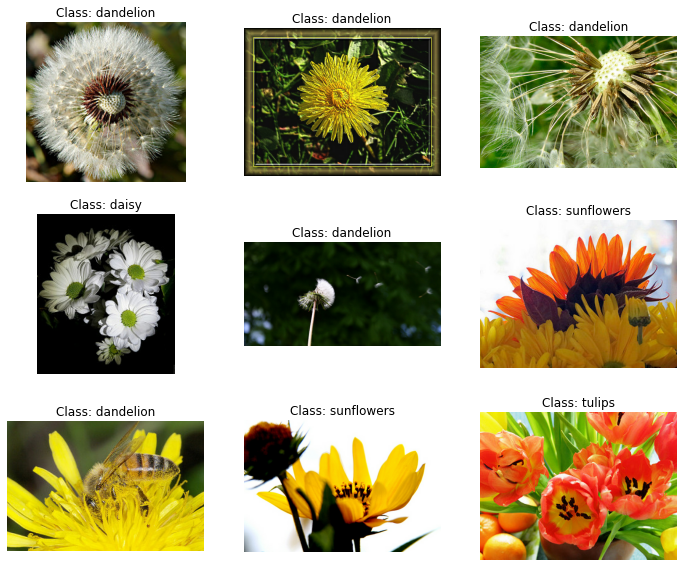

In [26]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

## Basic Preprocessing as per the Model Requirements

In [16]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

## Applying preprocessing to all the subsets of data

1. Shuffle the training set.
2. Apply the preprocess function and add batching & prefetching to all the subsets

In [30]:
batch_size = 32
train_set = train_set_raw.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

## Defining Model

1. Load the Xception Model from keras and exclude the top layer.
2. Define our own Polling layer and Dense output layer.
3. Set up the model with input and output.

In [27]:
pre_trained_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(pre_trained_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=pre_trained_model.input, outputs=output)

In [29]:
## set the trainable attribute to false for the pre_trained model.
for layer in pre_trained_model.layers:
    layer.trainable = False

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
86/86 [==============================] - 56s 652ms/step - loss: 0.5128 - accuracy: 0.8034 - val_loss: 0.4013 - val_accuracy: 0.8693
Epoch 2/5
86/86 [==============================] - 55s 640ms/step - loss: 0.2735 - accuracy: 0.9081 - val_loss: 0.3684 - val_accuracy: 0.8802
Epoch 3/5
86/86 [==============================] - 55s 643ms/step - loss: 0.2310 - accuracy: 0.9273 - val_loss: 0.3638 - val_accuracy: 0.8730
Epoch 4/5
79/86 [==========================>...] - ETA: 3s - loss: 0.2127 - accuracy: 0.9331

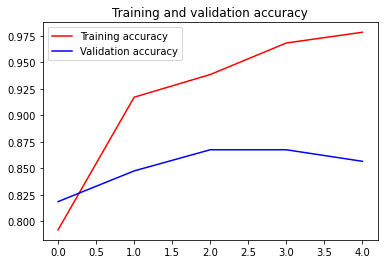

<Figure size 432x288 with 0 Axes>

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()